In [1]:
import cltplotting as helper # Helper module for this notebook

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Central Limit Theorem Explorer
### For Olivia by Ben

## 1. Frequentist statistics

In Frequentist hypothesis testing, we care about some aspect of a population (e.g. the average height $h$ of UK females) and we repeatedly sample this population to try to estimate that aspect. Continuing the example, we might measure the heights of 100 women, find the average $\hat{h}$, and conclude that $\hat{h}$ should be 'near' $h$. But how near?

In the Frequentist worldview (and in real life), the heights of UK women are some $\textit{fixed, nonrandom}$ histogram. We can abstract this to a random variable $H$ following some 'true' distribution. Each woman we measure is (we hope!) a $\textit{random, independent}$ sample $h_i$ from this distribution. Thus the question we want to investigate is: 'If I take the mean of $n$ independent samples from some distribution, how close will it be to the true mean?'

The mean h of this distribution is 5.0 ft


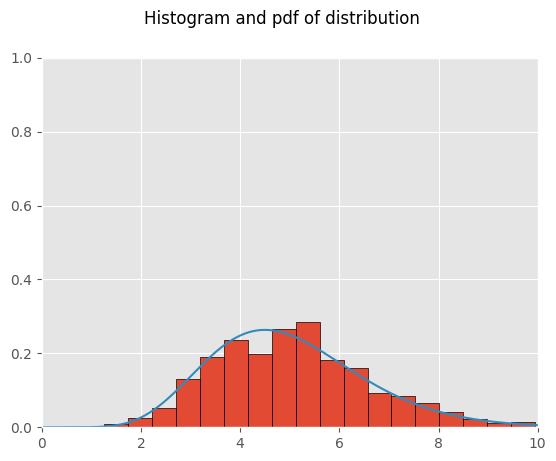

In [2]:
from scipy.stats import gamma

# Because I CBA to do aything more realistic, model heights of UK women by a gamma distribution
height_dist = gamma(a=10, scale=0.50)
_ = helper.distribution_histogram(height_dist, xrange=[0, 10])

print(f"The mean h of this distribution is {height_dist.mean()} ft")

### 1.1 Terminology
For the sake of precision, this is the terminology we will be using:
* $H$ is a random variable representing the heightof UK women
 * $H$ will be distributed according to some probability distribution, the true distribution
* $h_i$ are samples from $H$. These are constant values (our $\textit{data}$)
* We can alternatively write $H_i$ for independent copies of $H$, and each $h_i$ is sampled from the corresponding $H_i$
* $\hat{h}$ is the sample mean, $(h_1+...+h_n)/n$. This is a constant value
* $\hat{H}$ is the $\textit{random}$ sample mean, $(H_1+...+H_n)/n$. This is a random variable
 * We can view $\hat{h}$ as a single sample from $\hat{H}$
 * Unfortunately, terminology here is inconsistent - authors interchange $\hat{h}$ and $\hat{H}$, and call both the sample mean

Additionally the notation '$\sim$', where '$X\sim\mathcal{N}(0,1)$' means '$X$ is distributed according to $\mathcal{N}(0,1)$'.

Note that 'random variable' and 'the distribution of a random variable' are $\textit{different things}$, however this distinction is often elided and can cause confusion. You'll often see the abuse of notation '$X\sim Y$' as a shorthand for '$X$ is distributed according to the $\textit{distribution}$ of $Y$.

In [3]:
# Calculate the mean of heights of n random women

n = 100
h_hat = helper.compute_sample_mean(height_dist, n, 1)
print(f"Mean h_hat of a sample of {n} women is {h_hat[0].round(2)}")

Mean h_hat of a sample of 100 women is 4.98


Running this cell a few times should reinforce that the average of 100 samples of this height distribution is 'usually' 'very close' to the true value. In fact, because of the (very strong) assumption that the women were sampled independently from the same distribution, we can show mathematically that the average value of $\hat{H}$ is the true mean $h$!

Let's unpack this: we have 100 independent copies $H_i$ of $H$, so the (random) sample mean $\hat{H}=\frac{H_1+...+H_{100}}{100}$ is itself a random quantity. So we can talk about its average value $\mathbb{E}(\hat{H})$. We're claiming $\mathbb{E}(\hat{H})=\mathbb{E}(H)=h$.

$\textbf{Proof}$: since expectation is linear,
$$\mathbb{E}(\hat{H})=\mathbb{E}\left(\frac{H_1+...+H_{100}}{100}\right)=\frac{\mathbb{E}(H_1)+...+\mathbb{E}(H_{100})}{100}$$
Now since the $h_i$ are independent and distributed according to $H$,
$$\mathbb{E}(\hat{H})=\frac{100\mathbb{E}(H)}{100}=h$$

### 1.2. But what's the variance?
We know now that on average the sample mean equal the true mean. Can we quantify the variance? It should definitely depend on sample size. If I just sampled $\textit{one}$ woman, on average, her height would be near the true mean but the variance would be awful. If I sampled $\textit{every}$ woman, I would get the correct average height with zero variance!

Let's plot histograms of $\hat{H}$ for $n=1,5,10$:

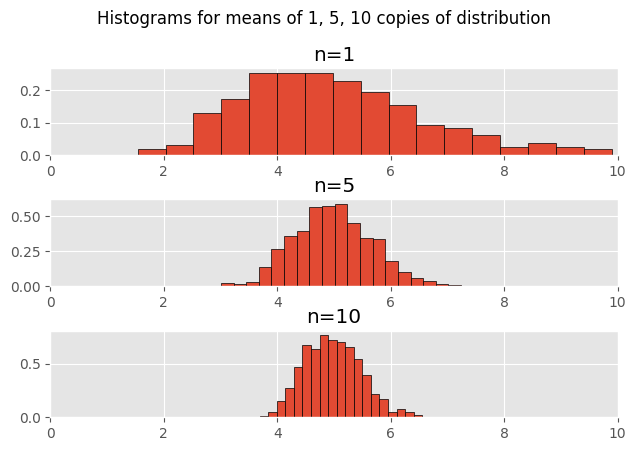

In [4]:
_ = helper.sample_mean_histogram(height_dist, [1, 5, 10], xrange=[0, 10])

For $n=1$, we're just plotting a histogram of $H$ (notice the slight skewness). As $n$ increases, we indeed see the histogram bunching up around the true mean. But something very surprising and much more powerful happens: $\textit{the histogram approaches a normal distribution}$

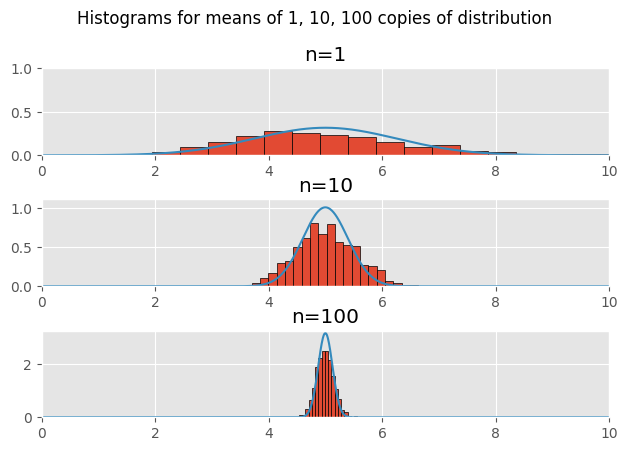

In [5]:
_ = helper.sample_mean_histogram_with_approx(height_dist, [1, 10, 100], xrange=[0, 10])

## 2. The Central Limit Theorem
This is the Central Limit Theorem. The blue histograms above will $\textit{exactly}$ match the orange Normal distribution as the sample size $n$ gets large.

Mathematically, it says that the average $\hat{H}$ of $n$ independent copies of a fixed random variable $H$ approaches a Normal distribution as $n$ becomes large. More precisely, it states that:
$$\hat{H}\rightsquigarrow\mathcal{N}\left(h,\frac{\sigma^2}{n}\right)\quad\textit{as }n\rightarrow\infty$$
where $h$ and $\sigma$ are the mean and standard deviation of $H$, and '$\rightsquigarrow$' means 'approaches this distribution'.

This is a bit of a mouthful. Another way of phrasing the theorem in plainer English is: If I average out more and more independent samples of a fixed distribution, it becomes equivalent to taking a single sample from a Normal distribution (with the correct mean and standard deviation).

A few things to note:
* This is true $\textit{regardless of the shape of}$ $H$
* This answers our variance question: as the sample size increases, the variance of the sample mean decreases like $1/n$. This allows us to construct Frequentist confidence intervals.
* Our original distribution $H$ had some skewness - but the normal distribution is symmetric (no skewness). Averaging out a lot of samples removes skewness!

$\textbf{Very important!}$ The Central Limit Theorem requires a few assumptions about the distribution we're getting our samples from. We'll revisit this is section 3.

### 2.1. Another Example: Gaussian Mixture
Let's do another example to reinforce what's happening: a mixture of two Normal distributions.

(The helpers that plot the normal approximation take any frozen scipy distribution, or more generally any class with the same signature as Bimodal_Normal below)

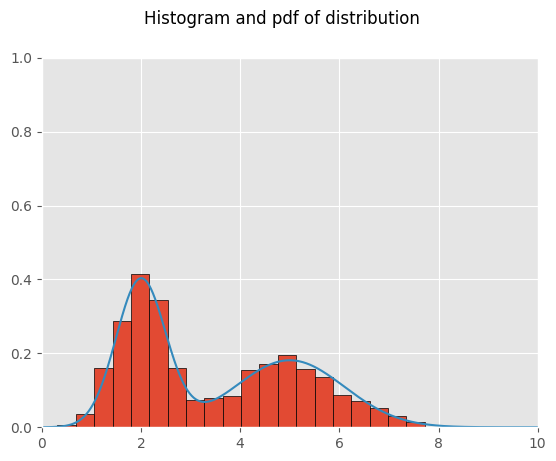

In [6]:
from scipy.stats.sampling import NumericalInversePolynomial
from scipy.stats import norm
import numpy as np


class Bimodal_Normal():
    ''' 50/50 mixture of N(m1, s1^2) and N(m1, s1^2) '''
    def __init__(self, m1, m2, s1, s2):
        self.m1 = m1
        self.m2 = m2
        self.s1 = s1
        self.s2 = s2
        
        self._prop_const = np.sqrt(2*np.pi)*(s1 + s2)
        return
    
    def pdf(self, x):
        ''' (Normalised) probability density function '''
        return np.exp(-(x-self.m1)**2/(2*self.s1**2)) / np.sqrt(8*np.pi*self.s1**2) + np.exp(-(x-self.m2)**2/(2*self.s2**2)) / np.sqrt(8*np.pi*self.s2**2)
    
    def mean(self):
        ''' Mean of the distribution '''
        return 0.5*(self.m1 + self.m2)
    
    def var(self):
        ''' Variance of the distribution '''
        return 0.5*(self.s1**2 + self.s2**2) + 0.25*(self.m1 - self.m2)**2
        
    def rvs(self, num_samples=1):
        ''' Sample from the distribution using NumericalInversePolynomial sampler'''
        sampler = NumericalInversePolynomial(self, random_state=np.random.default_rng())
        return sampler.rvs(num_samples)
    
bimodal_dist = Bimodal_Normal(m1=2, m2=5, s1=0.5, s2=1.1)
_ = helper.distribution_histogram(bimodal_dist, xrange=[0, 10])

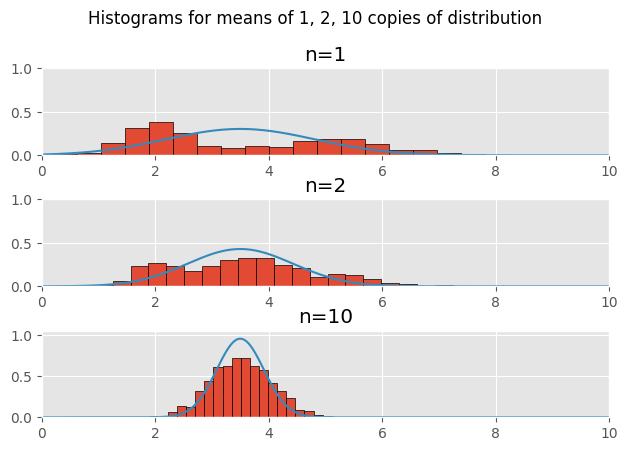

In [7]:
_ = helper.sample_mean_histogram_with_approx(bimodal_dist, [1, 2, 10], xrange=[0, 10])

The central limit theorem strikes again.

### 2.2. Another Example: Exponential distribution

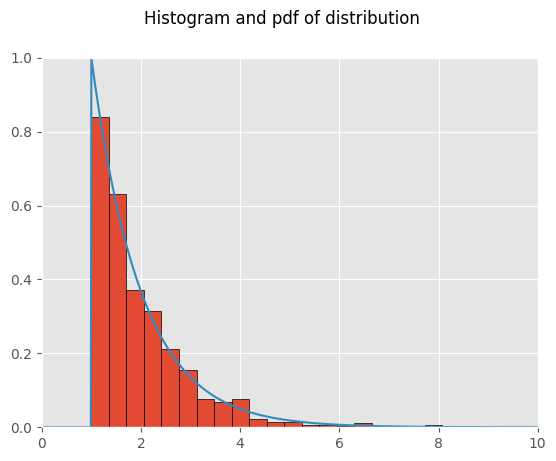

In [8]:
from scipy.stats import expon

exp_dist = expon(1)
_ = helper.distribution_histogram(exp_dist, xrange=[0, 10])

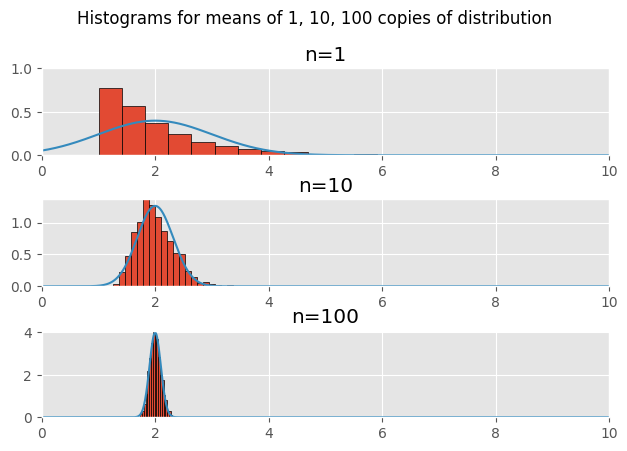

In [9]:
_ = helper.sample_mean_histogram_with_approx(exp_dist, [1, 10, 100], xrange=[0, 10])

## 3. Devil in the details (WIP)
The CLT underpins much of Frequentist statistics because it allows you to approximate everything with nice easy Normal distributions and form Frequentist confidence intervals. However, as the following examples will demonstrate, the CLT requires some assumptions that are rarely true in reality.

* Sample size: if the distribution has high variance/fat tails, the convergence to a normal distribution can be extremely slow (so you need unreasonably large sample sizes)
* Representability...
* Random sampling...
* Independence: the samples need to be independent (well, actually, they need to be *nearly* independent). In practice this is a huge barrier to the applicability of the central limit theorem
* Integrability: the distribution needs to have finite mean and finite variance

### 3.1 Cauchy distribution
The Cauchy distribution with parameters $x_0, \gamma$ has pdf
$$f(x,x_0,\gamma)=\frac{1}{\pi\gamma}\frac{1}{1+\left(\frac{x-x_0}{\gamma}\right)^2}$$

One place this distribution shows up: suppose I am perpendicular to an (infinite) wall andkick a football at it. If the angle I kick the ball is uniformly distributed on $(-90^\circ, 90^\circ)$, the position of the ball along the wall has a Cauchy distribution.

This is an innocuous distribution but has some disturbing properties! In particular, $\textit{this distribution has no mean or variance}$. Go on, try to calculate it!

In a fuzzy sense, this is because the tails are too fat. I won't go into the mathematical details, because I'm not convinced that the Cauchy distribution is relevant in real life. However, it is a good example to show the limits (ha ha) of the central limit theorem. One of the assumptions in the CLT is that the distribution needs to have $\textit{finite mean and finite variance}$.

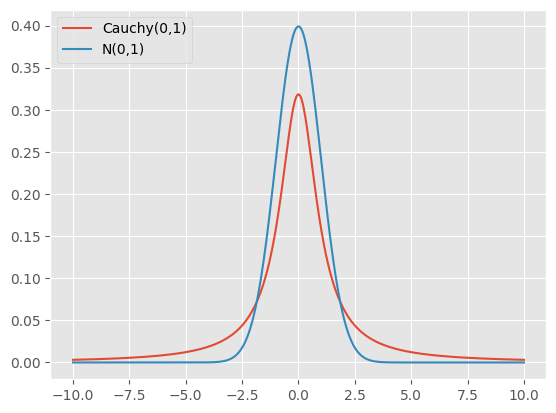

In [10]:
from scipy.stats import cauchy, norm
import numpy as np
import matplotlib.pyplot as plt

cauchy_dist = cauchy(0, 1)
normal_dist = norm(0, 1)
xs = np.linspace(-10, 10, 500)

fig, ax = plt.subplots(1, 1)
ax.plot(xs, cauchy_dist.pdf(xs), label="Cauchy(0,1)")
ax.plot(xs, normal_dist.pdf(xs), label="N(0,1)")
ax.legend(loc="upper left")
plt.show()

### 3.2 Trace Plots
Another way to visualise the central limit theorem is to look at a trace plot. We're going to keep sampling more and more values from a distribution, and plot their running average. We expect the running average to jump around, but converge to the true mean. For $\mathcal{N}(0,1)$, the trace plots do as you expect; they converge to the true distribution mean:

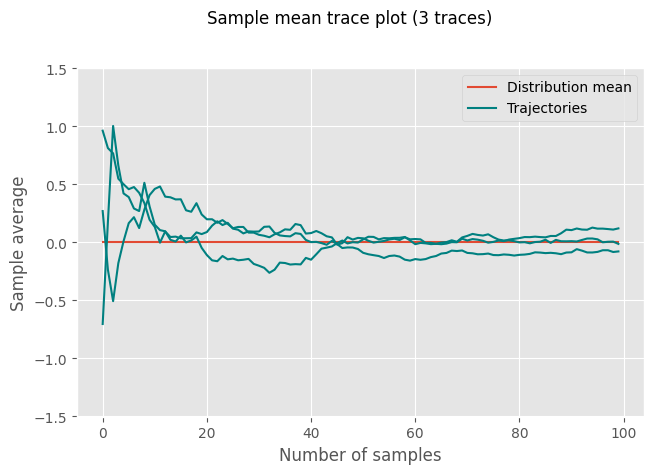

In [11]:
_ = helper.sample_mean_trace_plot(normal_dist, num_traces=3, num_samples=10**2)

Similarly, for a very skewed Gamma distribution $\Gamma(2, 0.05)$:

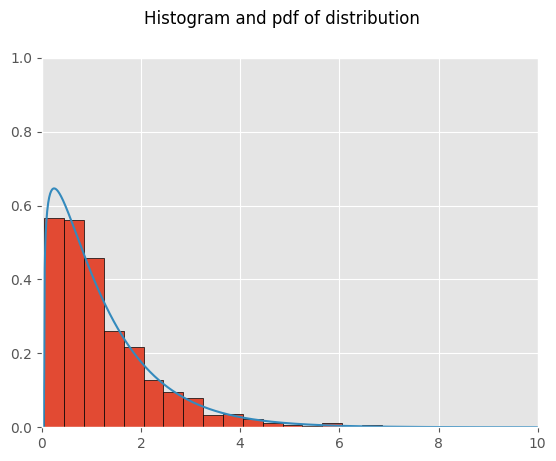

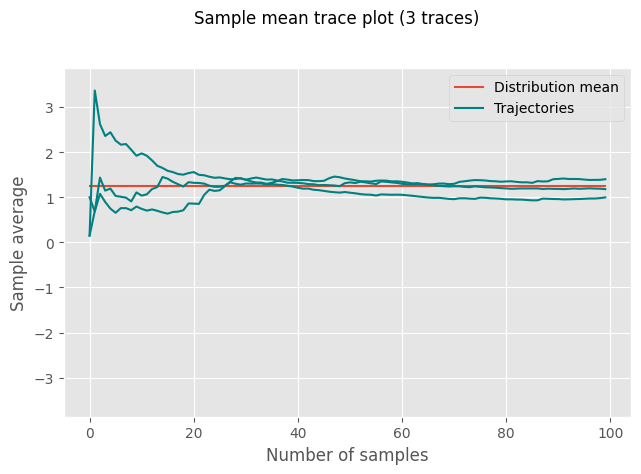

In [12]:
gamma_dist = gamma(1.2, 0.05)
_ = helper.distribution_histogram(gamma_dist, xrange=[0, 10])
_ = helper.sample_mean_trace_plot(gamma_dist, num_traces=3, num_samples=10**2)

For the Cauchy distribution, however, the trace plots never converge:

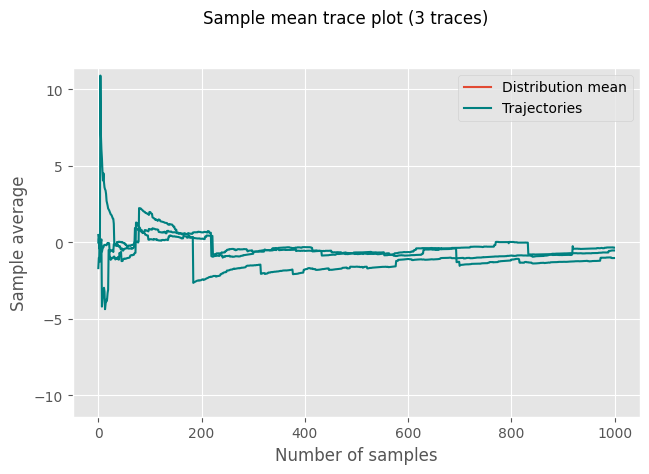

In [13]:
_ = helper.sample_mean_trace_plot(cauchy_dist, num_traces=3, num_samples=10**3)

The trace plots start converging to zero, but because the Cauchy distribution has extremely fat tails, we sometimes get unlucky and sample an extremely large value, large enough to overwhelm all of the previous samples...

The same is true for power laws (Pareto distributions) if the shape parameter is too small. This one might be more relevant in real life than the Cauchy, but I'm still unsure if this is a mathematical curiosity or a real restriction!

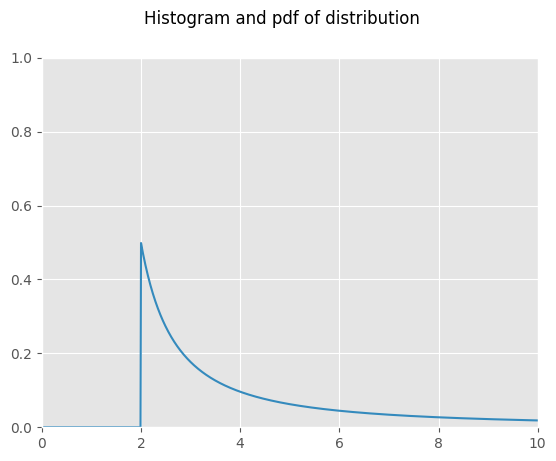

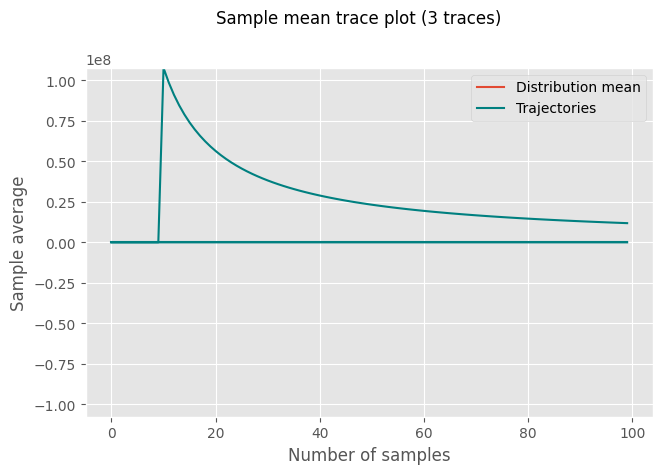

In [14]:
from scipy.stats import pareto

pareto_dist = pareto(loc=1, b=0.5)
_ = helper.distribution_histogram(pareto_dist, xrange=[0, 10])
_ = helper.sample_mean_trace_plot(pareto_dist, num_traces=3, num_samples=10**2)

## 4. Further reading (WIP)
When Googling the CLT, you'll get lots of different versions of the theorem with different sets complicated technical conditions. This is because the different assumptions of the CLT can be weakened or traded off against each other for particular classes of distributions. I'll go over these a little

* Identical distribution. We don't actually require the samples to be identically distributed - they just need to not 'spread out' too fast as to counteract the 'bunching' effect of taking averages (Lyapunov CLT)
* Dependence. We actually don't need independence of samples, we just need them to be $\textit{almost}$ independent for various possible operationalisations of 'almost'. One example (Strong Mixing CLT) says that if as $n$ increases my samples become independent of earlier samples, CLT is true.
* Fat tails...